## Testing hypothesis 3
---

**_Hypothesis_**: No publisher are able to get high scores (> 4.5) in more than 10 categories.

   - **Metric**: N. of times a publisher gets a score > 4.5 in different categories.
    
**Missing Values**:
  
- `publisher`: remove the entire sample
- `review/score`: remove the entire sample
- `categories`: remove the entire sample

**Data Transformation**:

- `categories`: GroupBy categories.
- `publisher`: GroupBy publisher.
- `review/score`: Compute the average review/score for each publisher.

---

In [133]:
# Connect to MongoDB

import pymongo

client = pymongo.MongoClient('mongodb://localhost:27017/')
database = client['spark_db']
books = database['books_hypothesis_7']

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Deal with missing values
pipeline_missing = {'$match':{
                         'review/score':{'$exists':True, '$ne':0.0},
                         'publisher':{'$exists':True, '$ne':None},
                         'categories':{'$exists':True},
                              }  
                    }    

# Compute average rating for each tuple category, publisher
pipeline_average_rating = {'$group':{
                                '_id':{
                                     'category':'$categories',
                                     'publisher':'$publisher',
                                     },
                                'avg_score':{'$avg':'$review/score'}
                                }
                           }

# Show average rating for category for each publisher
pipeline_publisher = {'$group': {
               '_id': '$_id.publisher',
               'avg_score/category': {
                    '$push': {
                         'category': '$_id.category',
                         'avg_score': '$avg_score'
                         }
                    }
               }
          }

# Unwind the list of categories
pipeline_unwind = {'$unwind':'$avg_score/category'}

# Count the number of categories with average rating > 4.5
pipeline_counts = {'$project': {
                         'publisher': '$_id',
                         '_id':0,
                         'category':'$avg_score/category.category',
                         'count': {
                              '$sum': {
                                   '$cond': {
                                   
                                        'if':{'$gt': ['$avg_score/category.avg_score', 4.5]},
                                        'then':1,
                                        'else':0
                                   }
                              }
                         }
                    }
               }

# Sum the results for each publisher. If Total > 10, then the hypothesis is False
pipeline_sum = {'$group': {
                    '_id': '$publisher', 
                    'total': {'$sum': '$count'}
                    }
                }

pipeline_sort = {'$sort':{
                         'total':-1
                         }
                }

results = books.aggregate([pipeline_missing, pipeline_average_rating, pipeline_publisher, pipeline_unwind, pipeline_counts, pipeline_sum, pipeline_sort])

df_results = pd.DataFrame(list(results))

<AxesSubplot: title={'center': 'Number of categories with average rating > 4.5 for each publisher'}, xlabel='publisher'>

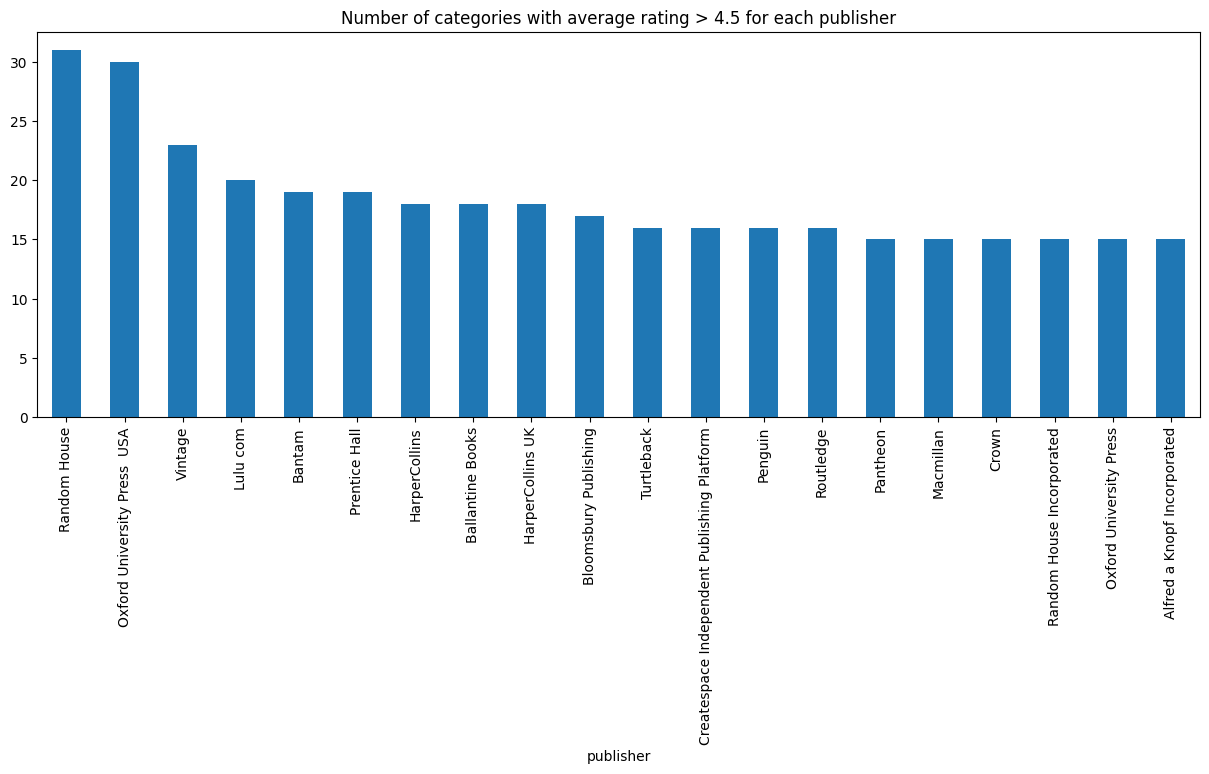

In [146]:
df_results.head(20).plot(x='_id', y='total', kind='bar', figsize=(15,5), xlabel = 'publisher', title='Number of categories with average rating > 4.5 for each publisher', legend=False)